# PAMAP2 - SE-Separable-Inception
- Inception(커널 크기를 다르게 설정하여 병렬 적용) + Depth-wise Separable Convolution
- 각 커널 별로 Depthwise -> Pointwise 진행 후 concat
- Inception + Xception 하이브리드 모델
- SE module 추가, 레이어를 하나 늘림

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary
from sklearn.manifold import TSNE
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def prepare_data_split(df, time_steps, steps, activity_mapping):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, time_steps, steps)
    return X_seq, y_seq.flatten()

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class SEBlock1D(nn.Module):
    """ 1D 데이터(시계열)를 위한 Squeeze-and-Excitation (SE) 블록 """
    def __init__(self, channels, reduction_ratio=16):
        """
        Args:
            channels (int): 입력 특징 맵의 채널 수 (C)
            reduction_ratio (int): Excitation 단계의 병목 구조에서 차원을 얼마나 줄일지에 대한 비율 (r)
        """
        super(SEBlock1D, self).__init__()

        # Squeeze: 입력 (B, C, L) -> 출력 (B, C, 1)
        self.gap = nn.AdaptiveAvgPool1d(1)

        # Excitation
        self.fc_stack = nn.Sequential(
            # FC 1: 채널 차원을 C -> C/r 로 압축 (병목). 1x1 Conv 사용
            nn.Conv1d(channels, channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            # FC 2: 채널 차원을 C/r -> C 로 다시 복원
            nn.Conv1d(channels // reduction_ratio, channels, kernel_size=1, bias=False),
            # Sigmoid: 0~1 사이의 값으로 채널별 중요도 가중치를 생성
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (B, C, L)

        # Squeeze
        x_squeeze = self.gap(x)  # shape: (B, C, 1)

        # Excitation
        excitation = self.fc_stack(x_squeeze) # shape: (B, C, 1) (채널별 가중치)

        # 3. Rescale (재조정)
        # 원본 입력 x (B, C, L)에 가중치 excitation (B, C, 1)을 채널별로 곱함
        # (B, C, 1)이 (B, C, L)로 브로드캐스팅되어 적용됨
        return x * excitation

In [ ]:
class SeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(SeparableConv1D, self).__init__()
        self.depthwise = nn.Conv1d(
            in_channels,
            in_channels,  # 출력 채널이 입력 채널과 동일
            kernel_size=kernel_size,
            groups=in_channels,  # 이 인자가 깊이별(depthwise) 연산을 정의함
            padding=padding,
            stride=stride
        )
        self.pointwise = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=1  # 1x1 커널을 사용해 채널을 결합 (pointwise)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [ ]:
class SeparableInceptionBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels_branch1, out_channels_branch2, out_channels_branch3, kernel_size1, kernel_size2, kernel_size3):
        super(SeparableInceptionBlock1D, self).__init__()

        # 각 커널에 맞는 패딩 계산
        padding1 = kernel_size1 // 2
        padding2 = kernel_size2 // 2
        padding3 = kernel_size3 // 2

        # Separable Conv 스택 (3개 브랜치)
        self.conv_path1 = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size1, groups=in_channels, padding=padding1, stride=1), # 깊이별(depthwise)
            nn.Conv1d(in_channels, out_channels_branch1, kernel_size=1), # 점별(pointwise)
            nn.BatchNorm1d(out_channels_branch1),
        )
        self.conv_path2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size2, groups=in_channels, padding=padding2, stride=1),
            nn.Conv1d(in_channels, out_channels_branch2, kernel_size=1),
            nn.BatchNorm1d(out_channels_branch2),
        )
        self.conv_path3 = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size3, groups=in_channels, padding=padding3, stride=1),
            nn.Conv1d(in_channels, out_channels_branch3, kernel_size=1),
            nn.BatchNorm1d(out_channels_branch3),
        )

        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.out_channels_total = out_channels_branch1 + out_channels_branch2 + out_channels_branch3
        self.se_block = SEBlock1D(self.out_channels_total)

        # Shortcut 경로 (Residual 연결)
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, self.out_channels_total, kernel_size=1, stride=2),
            nn.BatchNorm1d(self.out_channels_total)
        )

    def forward(self, x):
        shortcut_out = self.shortcut(x)

        # 3개 브랜치를 병렬로 실행하고, 채널 방향으로 결합
        x1 = self.conv_path1(x)
        x2 = self.conv_path2(x)
        x3 = self.conv_path3(x)

        conv_out = torch.cat([x1, x2, x3], dim=1)
        conv_out = self.maxpool(conv_out)
        conv_out = self.se_block(conv_out)
        return shortcut_out + conv_out

In [ ]:
class SESeparableInceptionHAR(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(SESeparableInceptionHAR, self).__init__()

        # 1. Stem: 초기 특징 추출
        self.stem = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # 2. Xception 블록 스택 (Middle Flow)
        # out_channels_total1 = 96+64+32 = 192
        self.block1 = SeparableInceptionBlock1D(64, 96, 64, 32, 3, 5, 7)
        # out_channels_total2 = 128+96+64 = 288
        self.block2 = SeparableInceptionBlock1D(192, 128, 96, 64, 3, 5, 7)
        # out_channels_total3 = 192+192+96 = 480
        self.block3 = SeparableInceptionBlock1D(288, 192, 192, 96, 3, 3, 5)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(480, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

    def get_features(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

LOOSV(Leave-One-Out-Subject-Validation)
- LOSO(Leave-One-Subject-Out)과 동일한 개념
- 피험자 한 명의 데이터를 테스트셋으로 번갈아 가며 사용
- Protocol_subject101, 102, 105, 106, 108을 제외한 피험자는 모든 클래스가 포함되어 있지 않아서 테스트 데이터로 부적합하다고 판단. 따라서 101, 102, 105, 106, 108만 LOOSV에 포함함

In [ ]:
# Start the main LOSO logic
# Load data
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

# Handle NaN values and map activities
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df['activityID'].isin(activity_mapping.keys())]

df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    activity_df[activity_df.select_dtypes(exclude='object').columns] = (
        activity_df.select_dtypes(exclude='object').interpolate(method='linear')
    )
    activity_df = activity_df.ffill().bfill()
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

In [ ]:
# Define constants
TIME_STEPS = 100
STEPS = 50
num_epochs = 100
patience = 20

# LOSO Subjects
loso_test_subjects = ['Protocol_subject101', 'Protocol_subject102', 'Protocol_subject105', 'Protocol_subject106', 'Protocol_subject108']
all_subjects = df_processed['subject'].unique().tolist()

# Lists to store results across all folds
all_preds = []
all_labels = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_X_test = []

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# LOSO Loop
for fold_idx, test_subject in enumerate(loso_test_subjects):
    print(f"--- Starting LOSO Fold {fold_idx + 1}/{len(loso_test_subjects)}: Test Subject: {test_subject} ---")

    # Set up training, validation, and test sets for the current fold
    if test_subject == 'Protocol_subject105':
        val_subject = 'Protocol_subject106'
    else:
        val_subject = 'Protocol_subject105'

    train_subjects = [s for s in all_subjects if s not in [test_subject, val_subject]]

    train_df = df_processed[df_processed['subject'].isin(train_subjects)].copy()
    val_df = df_processed[df_processed['subject'] == val_subject].copy()
    test_df = df_processed[df_processed['subject'] == test_subject].copy()

    # Scale data
    features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
    scaler = MinMaxScaler()
    train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    # Prepare data for PyTorch
    X_train, y_train = prepare_data_split(train_df, TIME_STEPS, STEPS, activity_mapping)
    X_val, y_val = prepare_data_split(val_df, TIME_STEPS, STEPS, activity_mapping)
    X_test, y_test = prepare_data_split(test_df, TIME_STEPS, STEPS, activity_mapping)
    all_X_test.append(X_test)

    train_dataset = PAMAP2Dataset(X_train, y_train)
    val_dataset = PAMAP2Dataset(X_val, y_val)
    test_dataset = PAMAP2Dataset(X_test, y_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize model, criterion, and optimizer for each fold
    input_features = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    model = SESeparableInceptionHAR(num_classes, input_features).to(device)

     # Print summary for the first fold only
    if fold_idx == 0:
        print("\n--- Model Summary (Fold 1) ---")
        summary(model, input_size=(input_features, TIME_STEPS))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, min_lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0

    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_acc)
        fold_val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'PAMAP2_Xception_best_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered for fold {fold_idx+1} after {epoch+1} epochs')
                break

    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_val_accuracies.append(fold_val_accuracies)

    # Evaluation on the test set
    model.load_state_dict(torch.load(f'PAMAP2_Xception_best_fold_{fold_idx}.pth'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(target.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

print("\nTraining completed!")

Using device: cuda
--- Starting LOSO Fold 1/5: Test Subject: Protocol_subject101 ---

--- Model Summary (Fold 1) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 50]          23,808
       BatchNorm1d-2               [-1, 64, 50]             128
              ReLU-3               [-1, 64, 50]               0
            Conv1d-4              [-1, 192, 25]          12,480
       BatchNorm1d-5              [-1, 192, 25]             384
              ReLU-6               [-1, 64, 50]               0
            Conv1d-7               [-1, 64, 50]             256
            Conv1d-8               [-1, 96, 50]           6,240
       BatchNorm1d-9               [-1, 96, 50]             192
             ReLU-10               [-1, 64, 50]               0
           Conv1d-11               [-1, 64, 50]             384
           Conv1d-12               [-1, 64, 50]   

In [ ]:
# 마지막 폴드에서 저장한 모델 로드
last_fold_idx = len(loso_test_subjects) - 1
model.load_state_dict(torch.load(f'PAMAP2_Xception_best_fold_{last_fold_idx}.pth'))

# 마지막 폴드의 train_loader를 사용하여 훈련 데이터에 대한 성능을 측정
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

# 마지막 폴드의 test_loader를 사용하여 테스트 데이터에 대한 성능을 측정
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 95.21%
Training loss: 0.1455
Test accuracy: 49.04%
Test loss: 3.5649


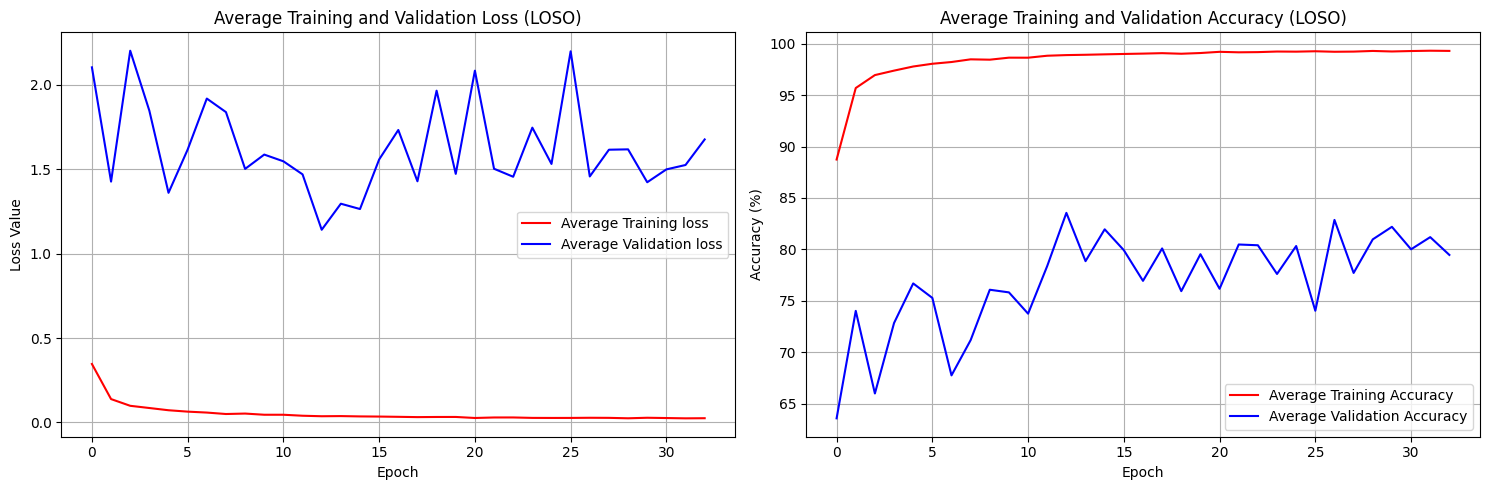

In [ ]:
# Aggregate and Visualize Final Results
max_len = max(len(l) for l in all_train_losses)
padded_train_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_losses])
padded_val_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_losses])
padded_train_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_accuracies])
padded_val_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_accuracies])

avg_train_loss = np.mean(padded_train_losses, axis=0)
avg_val_loss = np.mean(padded_val_losses, axis=0)
avg_train_acc = np.mean(padded_train_accuracies, axis=0)
avg_val_acc = np.mean(padded_val_accuracies, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, 'r', label='Average Training loss')
plt.plot(avg_val_loss, 'b', label='Average Validation loss')
plt.title('Average Training and Validation Loss (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, 'r', label='Average Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Final Classification Report (Aggregated LOSO) ---
                   precision    recall  f1-score   support

            lying     0.6773    0.8023    0.7345      2433
          sitting     0.7296    0.7035    0.7163      2374
         standing     0.8266    0.5332    0.6483      2378
          walking     0.6467    0.7512    0.6950      2882
          running     0.8511    0.5961    0.7011      1889
          cycling     0.7447    0.9342    0.8287      2385
   Nordic walking     0.6749    0.2686    0.3843      2636
 ascending stairs     0.7101    0.6465    0.6768      1451
descending stairs     0.2605    0.7229    0.3830      1274
  vacuum cleaning     0.6246    0.7664    0.6883      2269
          ironing     0.8627    0.6051    0.7113      3125
     rope jumping     0.6904    0.5661    0.6221       855

         accuracy                         0.6585     25951
        macro avg     0.6916    0.6580    0.6491     25951
     weighted avg     0.7105    0.6585    0.6602     25951

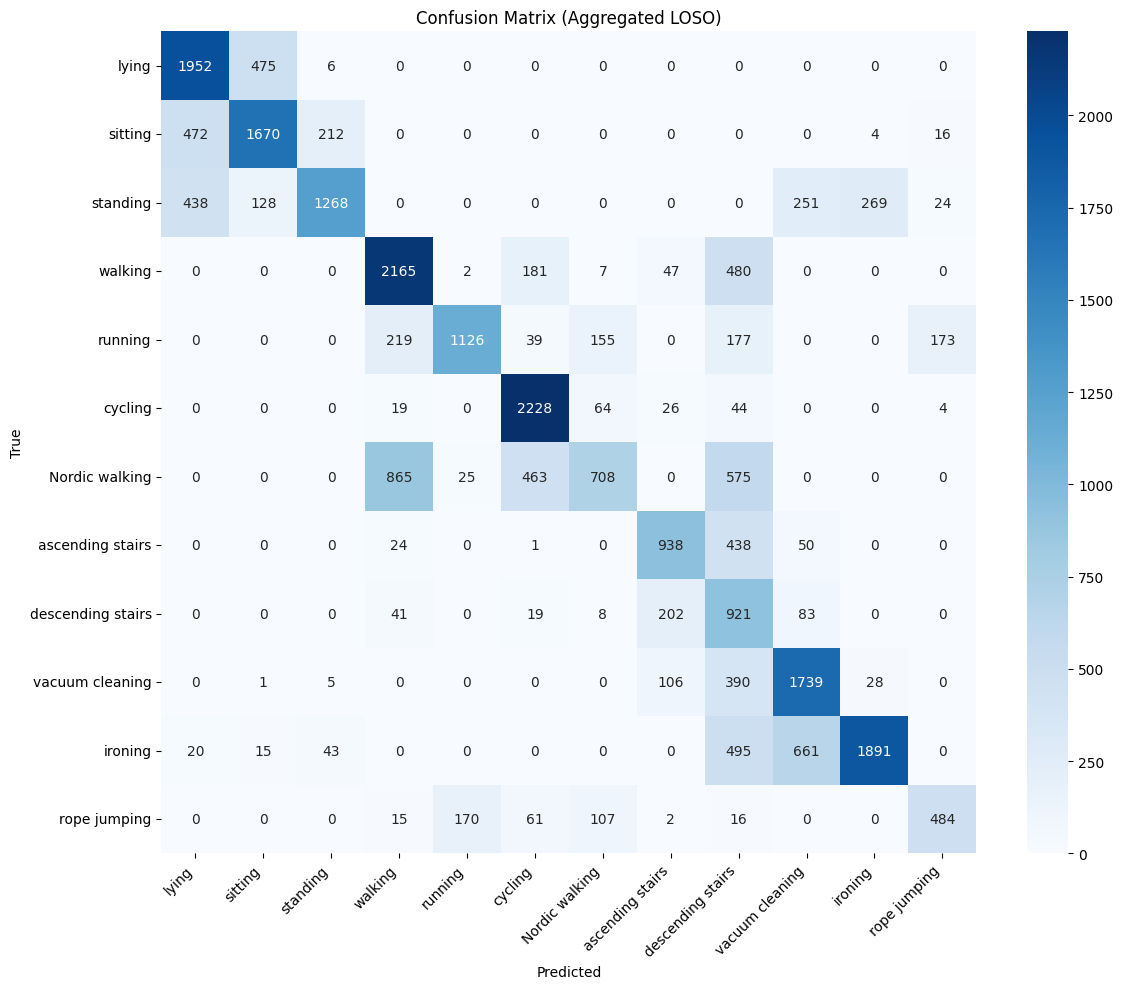

In [ ]:
# Final Classification Report and Confusion Matrix
print("\n--- Final Classification Report (Aggregated LOSO) ---")
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']
target_names = [LABELS[i] for i in np.unique(all_labels)]
print(classification_report(all_labels, all_preds, digits=4, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated LOSO)')
plt.gca().set_xticklabels(target_names, rotation=45, ha='right')
plt.gca().set_yticklabels(target_names, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# T-SNE Visualization
# 모든 테스트 데이터와 라벨을 합침
X_test_aggregated = np.concatenate(all_X_test, axis=0)
y_test_aggregated = np.array(all_labels)

# t-SNE는 계산량이 많으므로 일부 샘플만 사용
np.random.seed(42)
num_samples = 5000
if len(X_test_aggregated) > num_samples:
    indices = np.random.choice(len(X_test_aggregated), num_samples, replace=False)
    X_tsne = X_test_aggregated[indices]
    y_tsne = y_test_aggregated[indices]
else:
    X_tsne = X_test_aggregated
    y_tsne = y_test_aggregated

In [ ]:
# 1. 모델 적용 전 (원시 데이터) t-SNE
X_tsne_flat = X_tsne.reshape(X_tsne.shape[0], -1)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne_flat)

tsne_raw = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(X_tsne_scaled)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_raw[:, 0], y=tsne_raw[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Raw Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 7.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.366546


In [ ]:
# 2. 모델 적용 후 (특징) t-SNE
model.eval()
with torch.no_grad():
    test_data_tensor = torch.FloatTensor(X_tsne).to(device)
    test_data_tensor = test_data_tensor.permute(0, 2, 1)
    features = model.get_features(test_data_tensor).cpu().numpy()

tsne_features = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(features)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=y_tsne, palette=sns.color_palette("hsv", len(LABELS)), legend='full')
plt.title('t-SNE of Model Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()